In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from src.utils import ROOT_DIR
from src.dataset import CustomDataset
from src.models import Flamingo0S
from open_flamingo import create_model_and_transforms
import torch
import os
import matplotlib.pyplot as plt

In [2]:
LANG_MODEL_PATH=os.path.join(ROOT_DIR, 'data','pretrained_models','RedPajama-INCITE-Base-3B-v1')
CACHE_MODEL= os.path.join(ROOT_DIR, 'data','pretrained_models')
FLAMINGO_MODEL_PATH=os.path.join(ROOT_DIR, 'data','pretrained_models','OpenFlamingo-3B-vitl-mpt1b', 'checkpoint.pt' )

model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path=LANG_MODEL_PATH,
    tokenizer_path=LANG_MODEL_PATH,
    cross_attn_every_n_layers=2,
    cache_dir=os.path.join(ROOT_DIR, 'data','pretrained_models')
)
model.load_state_dict(torch.load(FLAMINGO_MODEL_PATH), strict=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Flamingo model initialized with 1089480736 trainable parameters


_IncompatibleKeys(missing_keys=['vision_encoder.class_embedding', 'vision_encoder.positional_embedding', 'vision_encoder.proj', 'vision_encoder.conv1.weight', 'vision_encoder.ln_pre.weight', 'vision_encoder.ln_pre.bias', 'vision_encoder.transformer.resblocks.0.ln_1.weight', 'vision_encoder.transformer.resblocks.0.ln_1.bias', 'vision_encoder.transformer.resblocks.0.attn.in_proj_weight', 'vision_encoder.transformer.resblocks.0.attn.in_proj_bias', 'vision_encoder.transformer.resblocks.0.attn.out_proj.weight', 'vision_encoder.transformer.resblocks.0.attn.out_proj.bias', 'vision_encoder.transformer.resblocks.0.ln_2.weight', 'vision_encoder.transformer.resblocks.0.ln_2.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.bias', 'vision_encoder.transformer.resblocks.1.ln_1.weight', 'vision_encoder.transformer.resbloc

In [19]:
from PIL import Image
import requests
import torch
from src.dataset import CustomDataset

"""
Step 1: Load images
"""


query_image = Image.open(
    requests.get(
        "http://images.cocodataset.org/test-stuff2017/000000028352.jpg", 
        stream=True
    ).raw
)
print(query_image)
vision_x = [image_processor(query_image).unsqueeze(0)]
print(np.array(vision_x).shape)
vision_x = torch.cat(vision_x, dim=0)
print(np.array(vision_x).shape)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)
print(np.array(vision_x).shape)
tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>Describe this image.<|endofchunk|><image>An image of"],
    return_tensors="pt",
)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500 at 0x7F0E3EF0BAD0>
(1, 1, 3, 224, 224)
(1, 3, 224, 224)
(1, 1, 1, 3, 224, 224)


In [4]:
vision_x

tensor([[[[[[ 0.5727,  0.5435,  0.7771,  ..., -0.2886, -0.2886, -0.4200],
            [ 0.6019,  0.5289,  0.7187,  ..., -0.3762, -0.3178, -0.3032],
            [ 0.6019,  0.5143,  0.7333,  ..., -0.3616, -0.3616, -0.4638],
            ...,
            [-0.2302, -0.2156, -0.3762,  ..., -1.7923, -1.7339, -1.7631],
            [-0.3324, -0.4346, -0.5806,  ..., -1.7193, -1.7485, -1.7339],
            [-0.8872, -0.9893, -1.1353,  ..., -1.6609, -1.6901, -1.6755]],

           [[ 0.5741,  0.8142,  1.2044,  ..., -0.9117, -0.9267, -1.0617],
            [ 0.5741,  0.7242,  1.1594,  ..., -0.9867, -0.9567, -0.9267],
            [ 0.5891,  0.6341,  1.1144,  ..., -0.9867, -0.9717, -1.0617],
            ...,
            [-1.4669, -1.4519, -1.5120,  ..., -1.6921, -1.7521, -1.7371],
            [-1.6621, -1.6320, -1.6621,  ..., -1.7221, -1.7221, -1.7371],
            [-1.6470, -1.6771, -1.7071,  ..., -1.6921, -1.7221, -1.7371]],

           [[ 0.4253,  0.8092,  1.1505,  ..., -0.9399, -0.9256, -0.9825],


In [5]:
generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)

print("Generated text: ", tokenizer.decode(generated_text[0]))

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image>Describe this image.<|endofchunk|><image>An image of a person or thing that is used as a symbol or representative of a particular thing or idea.



In [2]:
dataset = CustomDataset(
    csv_file=os.path.join(ROOT_DIR, "data", "MMHS150K", "MMHS150K_text_in_image.csv"),
    img_dir=os.path.join(ROOT_DIR, "data", "MMHS150K", "img_resized/"),
    split="test",
)

In [3]:
model = Flamingo0S(
    config_path=os.path.join(ROOT_DIR, "data", "config", "config_Flamingo0S.json")
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Flamingo model initialized with 1089480736 trainable parameters


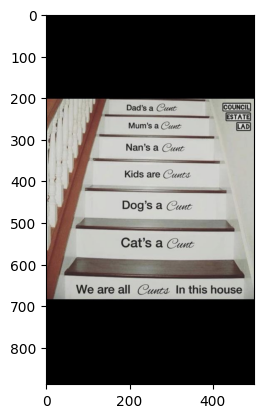

In [4]:
plt.imshow(dataset[2]['image'])

In [5]:
dataset[2]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x888>,
 'label': 0,
 'tweet_text': 'Day’s a cunt ',
 'img_text': "Dad's a Cunt Mum's a Cunt Nan's a Cunt Kids are Cunts COUNCIL STAT LAD Dog's a Cunt Cat's a unt We are all Cunts In this house "}

In [6]:
model(dataset[2])

{'input_ids': tensor([[50278,  6407,   314,    13,   368,  5513,    70,   253,  4495,   273,
           253,  5304,   629,    15, 32216,    13,   368,  5513,   253,  4495,
           273,   253, 45860,   629,    15,  6610,    13,   368,  1908,  5304,
           285, 45860,  4495,   281,  1167,    70,   347,  9239,  1020,   390,
          1327,    14,    73,   366,  1020,    15, 15490,   457,    84,   247,
           260,  2084,   209]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}


Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


{'generation': '<image>Firstly, you explaine the meaning of the visual part. Secondly, you explain the meaning of the textual part. Finally, you consider visual and textual meaning to meme as hateful or non-hateful.Day’s a cunt................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................'}